Comparando clasificadores. <br>

También implementado PCA y cross-validation.

En digits['images'] se encuentran las imágenes en matrices 8x8.
En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.
En digits['data'] se encuentra la información a entrenar. Tamaño: (1797, 64)
Ejemplo [ 0.  0.  5. 13.  9.  1.  0.  0.  0.  0. 13. 15. 10. 15.  5.  0.  0.  3.
 15.  2.  0. 11.  8.  0.  0.  4. 12.  0.  0.  8.  8.  0.  0.  5.  8.  0.
  0.  9.  8.  0.  0.  4. 11.  0.  1. 12.  7.  0.  0.  2. 14.  5. 10. 12.
  0.  0.  0.  0.  6. 13. 10.  0.  0.  0.] 



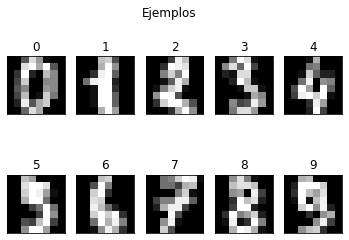

In [103]:
#Cargar dataset
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np

digits = datasets.load_digits()

print("En digits['images'] se encuentran las imágenes en matrices 8x8.")
print("En digits['target'] se encuentran las etiquetas para cada uno de los ejemplos.")
print(f"En digits['data'] se encuentra la información a entrenar. Tamaño: {digits['data'].shape}")
print("Ejemplo",digits["data"][0],"\n")

f,axes=plt.subplots(2,5)
f.suptitle("Ejemplos")
for num,ax in enumerate(axes.flatten()):
    ax.imshow(digits["images"][num],cmap='gray')
    ax.set_title(digits["target"][num])
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)



Verificar que las clases estén balanceadas


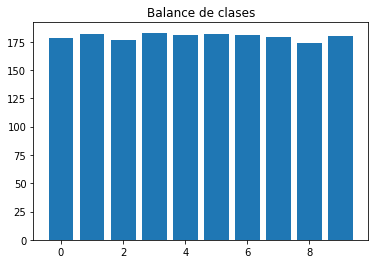

In [104]:
#Clases
plt.figure()
class_counts=np.unique(digits["target"], return_counts = True)
plt.bar(class_counts[0],class_counts[1])
plt.title("Balance de clases")
print("Verificar que las clases estén balanceadas")

In [86]:
#Organizar train-test
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(digits["data"],digits["target"],random_state=42,test_size=0.25)
print(f"Set de entrenamiento con el 25% de muestras: {X_train.shape}")

Set de entrenamiento con el 25% de muestras: (1347, 64)


Los primeros 21 componentes explican el 90.4% de la varianza de los dígitos.


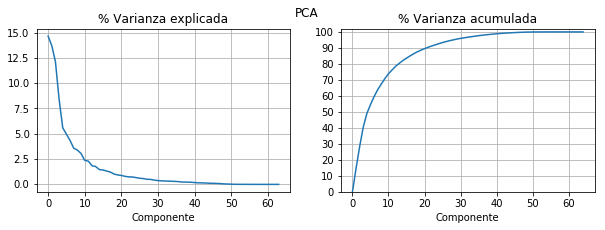

In [216]:
#PCA
from sklearn import decomposition
pca=decomposition.PCA()
X_pca_train=pca.fit_transform(X_train)

f,ax=plt.subplots(1,2,figsize=(10,3))
ax[0].plot(100*pca.explained_variance_ratio_)
f.suptitle("PCA")
ax[0].set_title("% Varianza explicada")
ax[0].set_xlabel("Componente")
ax[0].grid()

varianza_acumulada=np.cumsum(pca.explained_variance_ratio_)
ax[1].plot(100*np.concatenate([[0],varianza_acumulada]))
ax[1].set_title("% Varianza acumulada")
ax[1].set_xlabel("Componente")
ax[1].set_yticks(range(0,101,10))
ax[1].set_ylim(0,102)
ax[1].grid()

#Se busca el índice del PC desde desde el cual se ha explicado el 90% de la varianza
PCA_idx=np.argwhere(varianza_acumulada>0.9)[0][0]
X_pca_train=X_pca_train[:,:PCA_idx]
print(f"Los primeros {PCA_idx+1} componentes explican el {100*varianza_acumulada[PCA_idx]:.1f}% de la varianza de los dígitos.")

Separación de clases en los dos primeros componentes principales
En los dos primeros componentes se confunden varios números


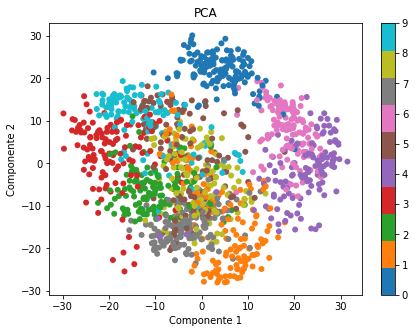

In [196]:
#Separación de componentes principales
plt.figure(figsize=(7,5))
plt.scatter(X_pca_train[:, 0], X_pca_train[:, 1], c=y_train, edgecolor='none', alpha=1,cmap=plt.cm.get_cmap('tab10', 10))
plt.xlabel('Componente 1')
plt.ylabel('Componente 2')
plt.colorbar()
plt.title("PCA")
print("Separación de clases en los dos primeros componentes principales")
print("En los dos primeros componentes se confunden varios números")